In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model = models.resnet50()

In [4]:
num_emotion_classes = 6  # Change as per your dataset
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),  # First additional layer
    nn.BatchNorm1d(256),                   # Batch Normalization
    nn.ReLU(),                             # Activation function
    nn.Dropout(0.3),                       # Dropout for regularization

    nn.Linear(256, 512),                   # Second additional layer
    nn.BatchNorm1d(512),                   # Batch Normalization
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(512, 256),                   # Third additional layer
    nn.BatchNorm1d(256),                   # Batch Normalization
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(256, num_emotion_classes)    # Final classification layer
)

# Move the model to the appropriate device
model = model.to(device)

In [5]:
checkpoint = torch.load("resnet50_finetune_64.pth", map_location=torch.device('cpu'))
print(checkpoint.keys()) 

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

C:\Users\adwik\AppData\Local\Temp\ipykernel_24912\58760503.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("resnet50_finetune_64.pth", map_locati

In [6]:
model.load_state_dict(torch.load(r"D:\SoulSync\resnet50_finetune_64.pth", map_location=device, weights_only=True))
# model.to(device)
# model.eval()  # Set the model to evaluation mode

# # Print the model architecture
# print(model)

<All keys matched successfully>

In [7]:
transform = transforms.Compose([
    transforms.Resize((72, 72)),  # Resize to 72x72
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

In [8]:
image_path =  r"D:\SoulSync\test_images\test_image_1.jpg"

In [9]:
image = Image.open(image_path).convert("RGB")
image.show()

In [10]:
image_resized = image.resize((72, 72))
# image_resized.show()

In [11]:
image = transform(image).unsqueeze(0)  # Add batch dimension

In [12]:
model.eval()

# Get the last layer output
with torch.no_grad():
    output = model(image)

print(output)

tensor([[-1.4152,  3.5152, -0.0955, -0.6140, -1.4859, -0.4243]])


In [13]:
import torch.nn.functional as F

# Apply softmax to the output
probabilities = F.softmax(output, dim=1)

print(probabilities)

tensor([[0.0067, 0.9289, 0.0251, 0.0150, 0.0063, 0.0181]])


In [14]:
valence = probabilities[0][0]*0.45 + probabilities[0][1]*0.3 + probabilities[0][2]*0.9 + probabilities[0][3]*0.77 + probabilities[0][4]*-0.82 + probabilities[0][5]*-0.4
arousal = probabilities[0][0]*0.2 + probabilities[0][1]*-0.98 + probabilities[0][2]*-0.56 + probabilities[0][3]*0.72 + probabilities[0][4]*-0.4 + probabilities[0][5]*0.8
valence = (valence+1)/2
arousal = (arousal+1)/2

In [15]:
print(valence, arousal)

tensor(0.6517) tensor(0.0498)


In [16]:
df = pd.read_json("top_881_track_metadata.json")

In [17]:
df

,track,artist,album,spotify_id,id,valence,arousal
0,Lucky,Jason Mraz,We Sing. We Dance. We Steal Things.,0IktbUcnAGrvD03AWnz3Q8,09I4YQcdsw1PVXh8,0.721,0.417
1,Joanne,Lady Gaga,Joanne (Deluxe),7dZ1Odmx9jWIweQSatnRqo,0CkkjxzAsaEnCq6E,0.134,0.424
2,Beautiful Girls,Sean Kingston,Beautiful Girls,1hGy2eLcmC8eKx7qr1tOqx,0H8rIoGIeSFQ9gyM,0.769,0.661
3,Want to Want Me,Jason Derülo,Everything Is 4,7oGZAicScQt96OAW4AruYy,0HA0ogRFA0jHan9J,0.656,0.680
4,Too Good at Goodbyes,Sam Smith,The Thrill Of It All (Special Edition),3VlbOrM6nYPprVvzBZllE5,0HNfZ7NMpnEWYRjW,0.523,0.373
...,...,...,...,...,...,...,...
876,Wet Dreamz,J. Cole,2014 Forest Hills Drive,6Ius4TC0L3cN74HT7ENE6e,zkRV3WqJN3gwKqfj,0.584,0.705
877,Everywhere,Fleetwood Mac,Tango In the Night (Deluxe Edition),254bXAqt3zP6P50BdQvEsq,zmD8tVWUJmOjvuDT,0.731,0.487
878,Romance,My Chemical Romance,The Black Parade,5wQnmLuC1W7ATsArWACrgW,zxkjK9m2IBpYzqWl,0.236,0.905
879,Mask Off,Future,FUTURE,0VgkVdmE4gld66l8iyGjgx,zxqKvtGMOMGE2ZeX,0.281,0.434


TypeError: text() missing 1 required positional argument: 's'

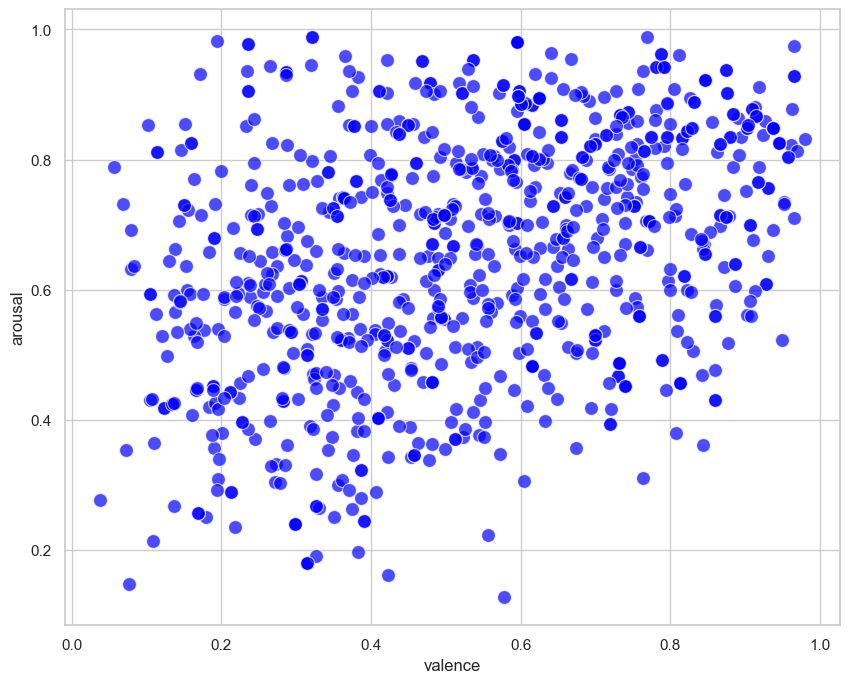

In [19]:
# Set up the plot
plt.figure(figsize=(10, 8))  # Set the figure size
sns.set(style="whitegrid")  # Set the style

# Create the scatter plot
scatter = sns.scatterplot(
    x='valence', 
    y='arousal', 
    data=df, 
    s=100,  # Size of the points
    color='blue',  # Color of the points
    alpha=0.7  # Transparency of the points
)

# Add labels to each point
for i, row in df.iterrows():
    plt.text(
        row['valence'] + 0.01,  # x-coordinate offset
        row['arousal'] + 0.01,  # y-coordinate offset
        fontsize=9,  # Font size
        fontweight='bold',  # Font weight
        color='darkblue'  # Text color
    )

# Add titles and labels
plt.title('Valence-Arousal Space of Songs', fontsize=16, fontweight='bold')
plt.xlabel('Valence', fontsize=14)
plt.ylabel('Arousal', fontsize=14)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
arousal = arousal.item()
valence = valence.item()

In [23]:
distance = np.sqrt((df['valence'] - valence) ** 2 + (df['arousal'] - arousal) ** 2)

# Find the closest point
closest_point = df.loc[distance.idxmin()]

# Display the closest point
print("Closest Point:")
print(closest_point)

Closest Point:
track                 Sweet Caroline
artist                  Neil Diamond
album                 Sweet Caroline
spotify_id    62AuGbAkt8Ox2IrFFb8GKV
id                  G4VU810Wqh1dlwb2
valence                        0.578
arousal                        0.127
Name: 209, dtype: object
